# Univariate time series analysis with ARIMA and SARIMA

<p style="text-align: justify">In this notebook, we conduct a univariate time series analysis on cryptocurrency data. The coin chosen is <a href="https://en.wikipedia.org/wiki/Ripple_(payment_protocol)">XRP</a> as it is one of the most popular cryptocurrency which recently got the 2nd position in terms of market capitalization, and which also has great potential in the future, in terms of payment and transaction speed. Indeed, XRP is often referenced as the "bankers coin", as institutions and banks have been partnering with Ripple for their different transaction enhancing procedures. 

<p style="text-align: justify">The historical data of the coin has been harvested on the web using the <a href="https://www.crummy.com/software/BeautifulSoup/">Beautiful Soup</a> library and saved in <em>csv</em> format, but this is not the purpose of this notebook. In case the reader is interested in this procedure, he can visit my <a href="https://github.com/DavidCico/Web-scraping-with-Beautiful-Soup-an-example-on-cryptocurrency-data">GitHub repository</a> on that matter.</p>

<p style="text-align: justify">The <b>"XRP_price"</b> dataset is a multivariate time series dataset that describes the historical price of the coin from almost its debut as exchanged currency. The data goes from August 2013 to December 2018, with daily observations of the different quantities. It is a multivariate series comprised of 3 variables (besides the date and time); they are:</p>

<ul>
<li><strong>Close XRP</strong>: The daily closing price of the cryptocurrency (\$USD).</li>
<li><strong>Volume XRP</strong>: The total daily volume of the coin (\$USD).</li>
<li><strong>Market Cap</strong>: The total daily market capitalization of the coin (\$USD).</li>
</ul>




In [1]:
# import regular libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# from SciPy packages
from statsmodels.tsa.stattools import adfuller # adfuller test
from statsmodels.graphics.tsaplots import plot_acf # autocorellation plot
from statsmodels.graphics.tsaplots import plot_pacf # partial autocorellation plot

# math function
from math import sqrt

# evaluation metrics
from sklearn.metrics import mean_squared_error

# statistics models
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# libraries to filter warnings in some algorithms
import warnings
warnings.filterwarnings("ignore")

## Load and Prepare Dataset

<p style="text-align: justify">After importing the different libraries that will be used in the code, we can use the <em>read_csv()</em> function to load the data and infer the first column containing the date data as an index.</p>

```python
dataset = pd.read_csv(name_coin + '_price.csv', header=0, infer_datetime_format=True, parse_dates=['Date'], index_col=['Date'])
```

<p style="text-align: justify">The dataset contains some <em>NaN</em> at the start of the historical data for the volume of the coin. These values are set to be 0 and won't influence the current study. We also make sure that the dataset is composed of floating point values of the same type.</p>

```python
# fill all NaN values with some particular value
dataset.fillna(0, inplace=True)

# make dataset numeric
dataset = dataset.astype('float32')
```

<p style="text-align: justify">We can perform some operations such as calculating the number of days per year in our dataset. This can easily be achieved using the <a href="https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.resample.html">resample() function</a> on the pandas DataFrame. Calling this function with the argument &#8216;<em>Y</em>&#8216; allows the loaded data indexed by date-time to be grouped by year (<a href="http://pandas.pydata.org/pandas-docs/stable/timeseries.html#offset-aliases">see all offset aliases</a>). We can then count the number of days for each year. Finally ,different properties of the dataset can be printed to check the statistics or shape for instance.</p>

In [2]:
# Write name of coin for study (XRP, BTC)
name_coin = 'XRP'

dataset = pd.read_csv(name_coin + '_price.csv', header=0, infer_datetime_format=True, parse_dates=['Date'], index_col=['Date'])

# fill all NaN values with some particular value
dataset.fillna(0, inplace=True)

# make dataset numeric
dataset = dataset.astype('float32')

# look at the values of the dataset
values = dataset.values

# Counting number of days per year
count_yearly_days =dataset['Close ' + name_coin].resample("Y").count()
print(count_yearly_days)
print()

# summarize dataset
print("Shape of the dataset :", dataset.shape)
print()
print("First rows of the dataset :", dataset.head())
print()
print("Statistics on the dataset :",dataset.describe())



# definition of a series from the values of the dataframe
series = pd.Series(values[:,0])
series.index = dataset.index
series.index.name = 'date'

Date
2013-12-31    149
2014-12-31    365
2015-12-31    365
2016-12-31    366
2017-12-31    365
2018-12-31    350
Freq: A-DEC, Name: Close XRP, dtype: int64

Shape of the dataset : (1960, 3)

First rows of the dataset :             Close XRP  Volume XRP  Market Cap XRP
Date                                             
2013-08-05   0.005613         0.0      43879156.0
2013-08-06   0.004680         0.0      36591008.0
2013-08-07   0.004417         0.0      34534120.0
2013-08-08   0.004254         0.0      33258632.0
2013-08-09   0.004291         0.0      33547504.0

Statistics on the dataset :          Close XRP    Volume XRP  Market Cap XRP
count  1960.000000  1.960000e+03    1.960000e+03
mean      0.164995  2.000525e+08    6.352879e+09
std       0.341782  6.846500e+08    1.334716e+10
min       0.002810  0.000000e+00    2.196991e+07
25%       0.006315  2.744888e+05    1.735673e+08
50%       0.008615  9.076330e+05    2.580457e+08
75%       0.211142  1.335985e+08    8.117047e+09
max       

## Time Series Data Visualization

<p style="text-align: justify">Then a series of curves can be plotted to visualize the dataset and understand if the data answers to a particular behaviour. The first type of plot visualization for time series is the line plot, which is done below for the evolution of the price with time. It can be seen that the price increased substantially since 2017, which is the year where most people became aware of cryptocurrencies. To have a better insight of the price evolution, we can plot the time series after taking its logarithm transformation. A <em>log</em> transformation is often used in order to turn a time series <a href="https://en.wikipedia.org/wiki/Stationary_process">stationary</a>, which is often required for analysis. In our case, the time series is not stationary which may require some differencing, and transformation operations.</p>

<p style="text-align: justify">Some linear time series forecasting methods assume a well-behaved distribution of observations (i.e. a bell curve or normal distribution). This can be explicitly checked using tools like statistical hypothesis tests. But plots can provide a useful first check of the distribution of observations both on raw observations and after any type of data transform has been performed. Concerning the histogram and kde plots, the curves are typical of an exponential decay.</p>

<p style="text-align: justify">Another type of plot that is useful to summarize the distribution of observations is the box and whisker plot. This plot draws a box around the 25th and 75th percentiles of the data that captures the middle 50% of observations. A line is drawn at the 50th percentile (the median) and whiskers are drawn above and below the box to summarize the general extents of the observations. Dots are drawn for outliers outside the whiskers or extents of the data. From the whiskers plot below, we can see the disparity in data with years. The first 3 years have much smaller values, and are almost insignificant compared to the values in 2017 and 2018. In some analysis, the first years would be considered as outliers, however here as the data available is not enough it is important to keep these years. Also, as seen on the log-log plot of the time series, some recurrent behaviour is seen, such as cycles with a big increase of the coin value in 2017 as explained above.</p>


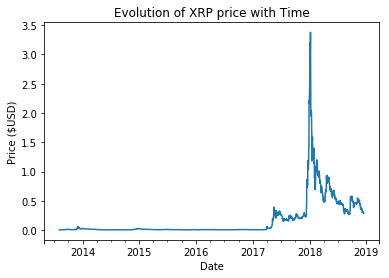

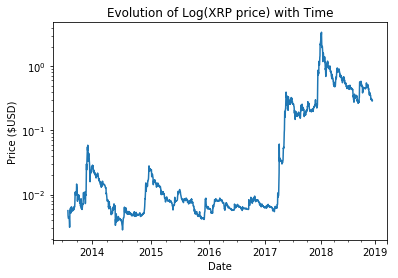

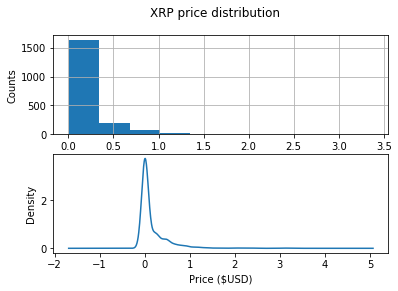

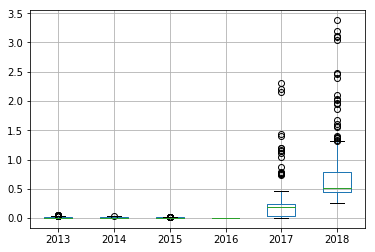

In [3]:
# plot the series against time
series.plot()
plt.ylabel('Price ($USD)')
plt.xlabel('Date')
plt.title('Evolution of XRP price with Time')
plt.show()

# plot the log of the time series against time
series.plot(loglog=True)
plt.ylabel('Price ($USD)')
plt.xlabel('Date')
plt.title('Evolution of Log(XRP price) with Time')
plt.show()

# density plot
plt.figure()
plt.suptitle('XRP price distribution')
plt.subplot(211)
plt.xlabel('Price ($USD)')
plt.ylabel('Counts')
series.hist()
plt.subplot(212)
plt.xlabel('Price ($USD)')
series.plot(kind='kde')
plt.show()

# Box and Whisker plots
groups = series['2013':'2018'].groupby(pd.Grouper(freq='Y'))

years_df = list()
for name, group in groups:
    df = pd.DataFrame()
    df[name.year] = group.values
    years_df.append(df)
# concatenate the columns of the different coins and save the dataset to a csv file
years = pd.concat(years_df, axis = 1, sort=False)

years.boxplot()
plt.show()

## Autocorrelation Analysis

<p style="text-align: justify">Statistical correlation summarizes the strength of the relationship between two variables.</p>

<p style="text-align: justify">We can assume the distribution of each variable fits a <a href="https://machinelearningmastery.com/statistical-data-distributions/">Gaussian</a> (bell curve) distribution. If this is the case, we can use the Pearson’s correlation coefficient to summarize the correlation between the variables.</p>

<p style="text-align: justify">The Pearson’s correlation coefficient is a number between -1 and 1 that describes a negative or positive correlation respectively. A value of zero indicates no correlation.</p>

<p style="text-align: justify">We can calculate the correlation for time series observations with observations with previous time steps, called lags. Because the correlation of the time series observations is calculated with values of the same series at previous times, this is called a serial correlation, or an autocorrelation.</p>

<p style="text-align: justify">A plot of the autocorrelation of a time series by lag is called the <a href="https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/">AutoCorrelation Function</a>, or the acronym ACF. This plot is sometimes called a <a href="https://en.wikipedia.org/wiki/Correlogram">correlogram</a>, or an autocorrelation plot.</p>

<p style="text-align: justify">A partial autocorrelation function or PACF is a summary of the relationship between an observation in a time series with observations at prior time steps with the relationships of intervening observations removed.</p>

<p style="text-align: justify">The autocorrelation for an observation and an observation at a prior time step is comprised of both the direct correlation and indirect correlations. These indirect correlations are a linear function of the correlation of the observation, with observations at intervening time steps.</p>

<p style="text-align: justify">It is these indirect correlations that the partial autocorrelation function seeks to remove. Without going into the math, this is the intuition for the partial autocorrelation.</p>

<p style="text-align: justify">We can calculate autocorrelation and partial autocorrelation plots using the <a href="http://www.statsmodels.org/dev/generated/statsmodels.graphics.tsaplots.plot_acf.html">plot_acf()</a> and <a href="http://www.statsmodels.org/dev/generated/statsmodels.graphics.tsaplots.plot_pacf.html">plot_pacf()</a> statsmodels functions respectively.</p>

<p style="text-align: justify">We can then create a single figure that contains both an ACF and a PACF plot. The number of lag time steps can be specified. We will fix this to be 100 days for the autocorrelation, and 50 days for the partial autocorrelation. We would expect that the price of the currency tomorrow, and in the coming week will be dependent upon the price from prior days. As such, we would expect to see a strong autocorrelation signal in the ACF and PACF plots.</p>

<p style="text-align: justify">We can clearly see a familiar autoregression pattern across the two plots. This pattern is comprised of two elements:</p>

<ul>
<li><strong>ACF</strong>: A large number of significant lag observations that slowly degrade as the lag increases.</li>
<li><strong>PACF</strong>: A few significant lag observations that abruptly drop as the lag increases.</li>
</ul>

<p style="text-align: justify">The ACF plot indicates that there is a strong autocorrelation component, whereas the PACF plot indicates that this component is distinct for the first approximately two lag observations. However, most of the lags are out of the interval of confidence, and it is difficult to characterize the current plot.</p>

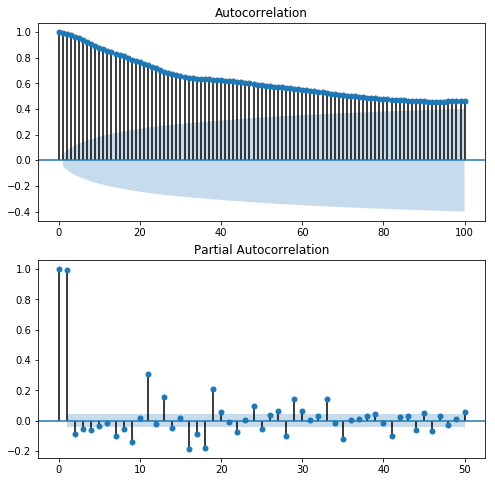

In [4]:
# plot Autocorrelation and Partial ACF plots
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize = (8,8))
plot_acf(series, lags =100, ax = ax1)
plot_pacf(series, lags =50, ax = ax2)
plt.show()

## Augmented Dickey-Fuller test
<p style="text-align: justify">Statistical tests make strong assumptions about your data. They can only be used to inform the degree to which a null hypothesis can be rejected or fail to be reject. The result must be interpreted for a given problem to be meaningful.</p>

<p style="text-align: justify">Nevertheless, they can provide a quick check and confirmatory evidence that your time series is stationary or non-stationary.</p>

<p style="text-align: justify">The <a href="https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test">Augmented Dickey-Fuller test</a> is a type of statistical test called a <a href="https://en.wikipedia.org/wiki/Unit_root_test">unit root test</a>.</p>

<p style="text-align: justify">The intuition behind a unit root test is that it determines how strongly a time series is defined by a trend.</p>

<p style="text-align: justify">There are a number of unit root tests and the Augmented Dickey-Fuller may be one of the more widely used. It uses an autoregressive model and optimizes an information criterion across multiple different lag values.</p>

<p style="text-align: justify">The null hypothesis of the test is that the time series can be represented by a unit root, that it is not stationary (has some time-dependent structure). The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.</p>

<ul>
<li><strong>Null Hypothesis (H0)</strong>: If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.</li>
<li><strong>Alternate Hypothesis (H1)</strong>: The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.</li>
</ul>

<p style="text-align: justify">We interpret this result using the p-value from the test. A p-value below a threshold (such as 5% or 1%) suggests we reject the null hypothesis (stationary), otherwise a p-value above the threshold suggests we fail to reject the null hypothesis (non-stationary).</p>
<ul>
<li><strong>p-value &gt; 0.05</strong>: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.</li>
<li><strong>p-value &lt;= 0.05</strong>: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.</li>
</ul>

<p style="text-align: justify">Below is an example of calculating the Augmented Dickey-Fuller test on the current dataset. The statsmodels library provides the <a href="http://statsmodels.sourceforge.net/devel/generated/statsmodels.tsa.stattools.adfuller.html">adfuller()</a> function that implements the test.</p>

In [5]:
# check if stationary
result = adfuller(series)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.122826
p-value: 0.024909
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


<p style="text-align: justify">Running the example outputs the result of a statistical significance test of whether the series is stationary. Specifically, the augmented Dickey-Fuller test.</p>

<p style="text-align: justify">The results show that the test statistic value -3.123 is smaller than the critical value at 5% of -2.863. This suggests that we can reject the null hypothesis with a significance level of less than 5% (i.e. a low probability that the result is a statistical fluke).</p>

<p style="text-align: justify">Rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is stationary or does not have time-dependent structure. Interestingly, the current time series can be considered stationary, when it doesn't seem to be so. This implies that no differencing operation will be required for analysis with the different models.</p>

## Evaluation metric

<p style="text-align: justify">A forecast will be comprised of seven values, one for each day of the week ahead.</p>
<p style="text-align: justify">It is common with multi-step forecasting problems to evaluate each forecasted time step separately. This is helpful for a few reasons:</p>
<ul>
<li>To comment on the skill at a specific lead time (e.g. +1 day vs +3 days).</li>
<li>To contrast models based on their skills at different lead times (e.g. models good at +1 day vs models good at days +5).</li>
</ul>
<p style="text-align: justify">Both <a href="https://en.wikipedia.org/wiki/Root-mean-square_deviation">Root Mean Squared Error (RMSE)</a> and <a href="https://en.wikipedia.org/wiki/Mean_absolute_error">Mean Absolute Error (MAE)</a> can be used to quantify the errors in price prediction (USD), although RMSE is more commonly used and will be adopted in this notebook. Unlike MAE, RMSE is more punishing of forecast errors.</p>
<p style="text-align: justify">The performance metric for this problem will be the RMSE for each lead time from day 1 to day 7. In this way, we can see how the chosen algorithms perform on the predictions at a particular day of the week. The cryptocurrency market is quite volatile, and may have a different behaviour depending on the period of the week (weekdays or weekend for instance).</p>
<p style="text-align: justify">As a short-cut, it may be useful to summarize the performance of a model using a single score in order to help in model selection. One possible score that could be used would be the RMSE across all forecast days.</p>

<p style="text-align: justify">The function <i>evaluate_forecasts()</i> below will implement this behavior and return the performance of a model based on multiple seven-day forecasts.</p>


In [6]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):
        # calculate mse
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculate rmse
        rmse = sqrt(mse)
        # store
        scores.append(rmse)
    # calculate overall RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

<p style="text-align: justify">Running the function will first return the overall RMSE regardless of day, then an array of RMSE scores for each day.</p>

## Train and Test Sets

<p style="text-align: justify">We will use the first 4 years of data for training predictive models and the final 2 years for evaluating models.</p>

<p style="text-align: justify">The data in a given dataset will be divided into standard weeks. These are weeks that begin on a Monday and end on a Sunday.</p>

<p style="text-align: justify">This is a realistic and useful way for using the chosen framing of the model, where the price for the week ahead can be predicted. It is also helpful with modeling, where models can be used to predict a specific day (e.g. Wednesday) or the entire sequence.</p>

<p style="text-align: justify">We will split the data into standard weeks, working backwards from the test dataset. This gives 178 weeks of data for the training set and 102 weeks (714 days) for the testing set.</p>

<p style="text-align: justify">The function <em>split_dataset()</em> below splits the daily data into train and test sets and organizes each into standard weeks. The "<i>n_test</i>" argument corresponds to the number of days (714 in this study), to cut the data backwards.</p>

<p style="text-align: justify">Specific row offsets are used to split the data using knowledge of the dataset. The split datasets are then organized into weekly data using the NumPy <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.split.html">split() function</a>.</p>

In [7]:
# split a univariate dataset into train/test sets
def split_dataset(data, n_test):
    # split into standard weeks
    train, test = data[0:-n_test], data[-n_test:]
    # restructure into windows of weekly data
    train = np.array(np.split(train, len(train)/7))
    test = np.array(np.split(test, len(test)/7))
    return train, test

# testing the procedure on the current data
n_test = 714 # number of days to split the dataset in weekly windows
train, test = split_dataset(values, n_test)
# validate train data
print("Training dataset shape :", train.shape)
print("First row :", train[0, 0, :], "; Last row :" ,train[-1, -1, :])
# validate test
print("Testing dataset shape :", test.shape)
print("First row :", test[0, 0, :], "; Last row :" ,test[-1, -1, :])

Training dataset shape : (178, 7, 3)
First row : [5.6130001e-03 0.0000000e+00 4.3879156e+07] ; Last row : [6.3680001e-03 4.1897800e+05 2.3140864e+08]
Testing dataset shape : (102, 7, 3)
First row : [6.311000e-03 1.046250e+06 2.293127e+08] ; Last row : [2.8792900e-01 3.1613594e+08 1.1784051e+10]


## Walk-forward validation

<p style="text-align: justify">Models will be evaluated using a scheme called <a href="https://en.wikipedia.org/wiki/Walk_forward_optimization">walk-forward validation</a>.</p>

<p style="text-align: justify">This is where a model is required to make a one week prediction, then the actual data for that week is made available to the model so that it can be used as the basis for making a prediction on the subsequent week. This is both realistic for how the model may be used in practice and beneficial to the models allowing them to make use of the best available data.</p>

<p style="text-align: justify">We can demonstrate this below with separation of input data and output/predicted data.</p>

    Input, 						Predict
    [Week1]						Week2
    [Week1 + Week2]				Week3
    [Week1 + Week2 + Week3]		Week4

<p style="text-align: justify">The walk-forward validation approach to evaluating predictive models on this dataset is implement below, named <em>evaluate_model()</em>.</p>

<p style="text-align: justify">The name of a function is provided for the model as the argument "<em>model_func</em>";. This function is responsible for defining the model, fitting the model on the training data, and making a one-week forecast.</p>

<p style="text-align: justify">The forecasts made by the model are then evaluated against the test dataset using the previously defined <em>evaluate_forecasts()</em> function.</p>

In [8]:
def evaluate_model(model_func, train, test, *args):
    #history of weekly data
    history = [x for x in train]
    #walk forward validation
    predictions = list()
    for i in range(len(test)):
    #weekly prediction
        y_hat_seq = model_func(history, *args)
    #store the preditions
        predictions.append(y_hat_seq)
    #update history data
        history.append(test[i,:])
    predictions = np.array(predictions)
    # evaluate predictions days for each week
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores, predictions

<p style="text-align: justify">Once we have the evaluation for a model, we can summarize the performance.</p>

<p style="text-align: justify">The function below named <em>summarize_scores()</em> will display the performance of a model as a single line for easy comparison with other models.</p>

In [9]:
#Summarize scores
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: Total RMSE --> [%.3f]; Daily RMSE: %s' % (name, score, s_scores))

## Develop an Autoregression Model

<p style="text-align: justify">The <em>to_series()</em> function below will take the multivariate data divided into weekly windows and will return a single univariate time series.</p>

In [10]:
# convert windows of weekly multivariate data into a series of closing price
def to_series(data):
    # extract just the price of XRP from each week
    series = [week[:, 0] for week in data]
    # flatten into a single series
    series = np.array(series).flatten()
    return series

<p style="text-align: justify">We can develop an autoregression model for univariate series of daily power consumption.

<p style="text-align: justify">The Statsmodels library provides multiple ways of developing an AR model, such as using the AR, ARMA, ARIMA, and SARIMAX classes.</p>

<p style="text-align: justify">We will use the <a href="http://www.statsmodels.org/dev/generated/statsmodels.tsa.arima_model.ARIMA.html">ARIMA implementation</a> as it allows for easy expandability into differencing and moving average. </p>

<p style="text-align: justify">The <em>arima_forecast()</em> function defined below implements the procedure for doing a prediction with an ARIMA model. First, the history data comprised of weeks of prior observations must be converted into a univariate time series of daily power consumption. We can use the <em>to_series()</em> function developed in the previous section.</p>

```python
# convert history into a univariate series
series = to_series(history)
```
<p style="text-align: justify">Next, an ARIMA model can be defined by passing order arguments ("<em>arima_order</em>") to the constructor of the ARIMA class. And the model can be fit on the training data. We will use the defaults and disable all debugging information during the fit by setting <em>disp=False</em>.</p>

```python
# define the model
model = ARIMA(series, order=arima_order)
# fit the model
model_fit = model.fit(disp=False)
```

<p style="text-align: justify">Now that the model has been fit, we can make a prediction.</p>

<p style="text-align: justify">A prediction can be made by calling the <em>predict()</em> function and passing it either an interval of dates or indices relative to the training data. We will use indices starting with the first time step beyond the training data and extending it six more days, giving a total of a seven day forecast period beyond the training dataset.</p>

```python
# make forecast
yhat = model_fit.predict(len(series), len(series)+6)
```


In [11]:
# Arima forecast for weekly prediction
def arima_forecast(history, arima_order):
    # convert history into a univariate series
    series = to_series(history)
    # define the model
    model = ARIMA(series, order=arima_order)
    # fit the model
    model_fit = model.fit(disp=False)
    # make forecast
    yhat = model_fit.predict(len(series), len(series)+6)
    return yhat

<p style="text-align: justify">The seasonal ARIMA model <a href="https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html">SARIMA</a>, can also be implemented in a similar way as the ARIMA model. The <em>Sarima_forecast</em> function below implements the same procedure as above, with the <em>"config"</em> argument defining the configuration of the chosen SARIMA model. The seasonal ARIMA model takes more parameters than the regular ARIMA model, to characterize some seasonal trends that might be present inside the dataset.</p>

In [12]:
# Sarima forecast for weekly prediction
def Sarima_forecast(history, config):
    order, sorder, trend = config
    # convert history into a univariate series
    series = to_series(history)
    # define model
    model = SARIMAX(series, order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
    # fit model
    model_fit = model.fit(disp=False)
    # make one step forecast
    yhat = model_fit.predict(len(series), len(series)+6)
    return yhat

<p style="text-align: justify">A grid search with hyperparameters has been carried out to find the most suitable ARIMA and SARIMA models for the current study. We find that <b>ARIMA(1,0,0)</b> and <b>SARIMA((1,0,0),(0,0,2,0),'n')</b> give the best results out of the different parameters tested, in this configuration.</p> 

<p style="text-align: justify">A dictionary containing both models is then created, to store the names of the models, which will be useful for future looping functions. Both orders are defined as <em>"arima_order"</em> for ARIMA, and <em>"config_sarima"</em> for the SARIMA model. Both parameters are stored in a list <em>"orders"</em> that will be called in the evaluation of the algorithms.</p>

In [13]:
# define the names and functions for the models we wish to evaluate
models = dict()
models['arima'] = arima_forecast
models['Sarima'] = Sarima_forecast

# define both parameters for the 2 models
arima_order = (1,0,0)
config_sarima = (1,0,0),(0,0,2,0),'n'

# list creation to store the parameters
orders = list()
orders.extend([arima_order, config_sarima])

# list containing the days of the week for plot on a particular day
days = ['mon', 'tue', 'wed', 'thr', 'fri', 'sat', 'sun']

<p style="text-align: justify">After defining the different functions, it is now possible to evaluate the different algorithms, summarizing their scores and plotting the RMSE for each day of the week. The function <em>evaluate_algorithms()</em> below implements this procedure by looping over the dictionary of models, and saving the predictions of each model in a list of results, to be used for plots afterwards.</p>

In [14]:
# evaluate each model
def evaluate_algorithms(models, orders):
    prediction_simulations = list()
    for (name, func), order in zip(models.items(), orders): # loop on dictionary items and list orders at same time
        # evaluate and get scores
        score, scores, predictions = evaluate_model(func, train, test, order)
        # summarize scores
        summarize_scores(name, score, scores)
        # plot scores
        plt.plot(days, scores, marker='o', label=name)
        # append the simulation results in a list
        prediction_simulations.append(predictions)
    # plot properties and showing
    plt.ylabel('RMSE')
    plt.legend()
    plt.show()
    return prediction_simulations

<p style="text-align: justify">The function <em>plot_forecasts()</em> creates a plot showing the evolution of the cryptocurrency price for the testing set, and the predictions made by ARIMA and SARIMA models.</p>

<p style="text-align: justify">It is also interesting to look at the residuals between prediction and testing data. A dictionary <em>"residuals_model"</em> is first created to store the dataframes that will contain the residuals for the models, with their names as keys. The function <em>plot_residuals()</em> is the implemented to create a figure with 3 subplots, showing from top to bottom:</p>

<ul>
    <li>Evolution of residuals with time for both models.</li>
    <li>Histogram of the distributions of the residuals</li>
    <li>Kernel density estimation of the residuals distributions</li>
</ul>

In [15]:
# plot the forecasts in the context of the original dataset
def plot_forecasts(models, train, test, prediction_simulations, colors ,n_test):
    # reshape train and tests set --> flattened for each feature
    train = np.reshape(train, (train.shape[0]*train.shape[1],train.shape[2]))
    test = np.reshape(test, (test.shape[0]*test.shape[1],test.shape[2]))
    
    #plt.plot(train) # plot training dataset
    plt.plot([None for i in train] + [x for x in test[:,0]], color = 'green', label="testing set")
    
    for i, (name, model), color in zip(range(len(prediction_simulations)), models.items(), colors): # looping over all results and arguments together 
        predictions = np.array(prediction_simulations[i]).flatten() # flatten predictions
        plt.plot([None for i in train] + [i for i in predictions] , color=color, label=name)
     
    # define different properties on the plot
    plt.xlabel('Days')
    plt.ylabel('Price ($)')
    plt.suptitle("Evolution of XRP price with time",fontsize=18, fontweight='bold')
    plt.legend()
    # show the plot
    plt.show()

    
residuals_model = dict() # initialize dictionary to store dataframes of residuals


def plot_residuals(models, test, prediction_simulations, colors,n_test):
    
    
    
    # redefine train and test set without the weekly reshaping
    test = np.reshape(test, (test.shape[0]*test.shape[1],test.shape[2])) # flatten test matrix
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize = (8,8)) # figure creation with 2 subplots
    
    for i, (name, model), color in zip(range(len(prediction_simulations)), models.items(), colors): # looping over all results and arguments together
        predictions = np.array(prediction_simulations[i]).flatten() # flatten predictions
        residuals = [test[i,0] - predictions[i] for i in range(len(test))] # list comprehension to calculate residuals
        residuals = pd.DataFrame(residuals) # creates a dataframe
        residuals.plot(kind = 'line', ax = ax1, color=color) # line plot
        residuals.hist(ax = ax2, bins = 30, color=color) # histogram
        residuals.plot(kind = 'kde', ax = ax3, color=color) # kernel density estimation
        
        residuals_model[name] = residuals # store the residuals dataframe inside the dictionary
        
    # define different properties on the plot
    ax1.set_ylabel('Residual value ($)')
    ax1.set_xlabel('Time (days)')
    ax2.set_ylabel('Counts')
    plt.xlabel('Price ($)')
    ax1.legend(['arima','Sarima'])
    ax2.legend(['arima','Sarima'])
    ax3.legend(['arima','Sarima'])
    fig.suptitle(r'Evolution of the residuals', fontsize=18, fontweight='bold', y=0.92)
    # show the plot
    plt.show()

<p style="text-align: justify">The script below defines all the parameters necessary to run the simulation, split the dataset into a training and testing dataset, and call the <em>evaluate_algorithms()</em> function to make predictions on the testing dataset with ARIMA and SARIMA models.</p>

arima: Total RMSE --> [0.195]; Daily RMSE: 0.1, 0.2, 0.2, 0.2, 0.2, 0.2, 0.3
Sarima: Total RMSE --> [0.242]; Daily RMSE: 0.1, 0.2, 0.2, 0.2, 0.3, 0.3, 0.3


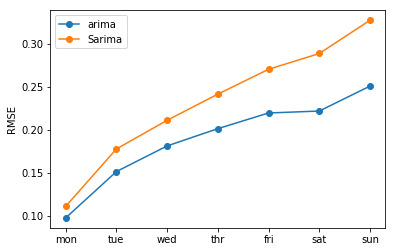

In [16]:
n_test = 714 # Splitting the dataset 714 days before the end

#n_tests = [714, 350, 1400]
# define the names and functions for the models we wish to evaluate
models = dict()
models['arima'] = arima_forecast
models['Sarima'] = Sarima_forecast

arima_order = (1,0,0)
config_sarima = (1,0,0),(0,0,2,0),'n'

orders = list()
orders.extend([arima_order, config_sarima])


# Creating a list of colors to be passed as arguments for the plots
colors = list()
colors.extend(['red','blue'])

#for n_test in n_tests:
train, test = split_dataset(dataset.values, n_test)

# evaluate the different algorithms defined in "models" dictionary
prediction_simulations = evaluate_algorithms(models, orders)

<p style="text-align: justify">As seen on the figure above, and the printed scores, the ARIMA model performs better than the SARIMA model. This is expected, considering that we are using rolling windows of 7 days in which, a seasonal pattern should hardly exist. Considering the training and testing dataset as a whole for instance would lead to different results as seasonal patterns do exist, especially when considering cryptocurrencies or other financial assets.</p>

<p style="text-align: justify">The RMSE error also increases as the week goes on. Indeed, considering the models are autoregressive with a lag of 1, the error gradually increases through the week depending on the evolution of the price compared to monday.</p>

<p style="text-align: justify">The evolution of price with time is then plotted for the predictions and the testing dataset. It can be seen why the error increases with the AR(1) model, especially when considering a cryptocurrency such as XRP, which is quite volatile. For the ARIMA model, the weekly prediction is based on the value from the previous week, with some seasonal moving average added in the SARIMA model. This shows the limitations of the models here despite the hyper-grid search carried out previously.</p>

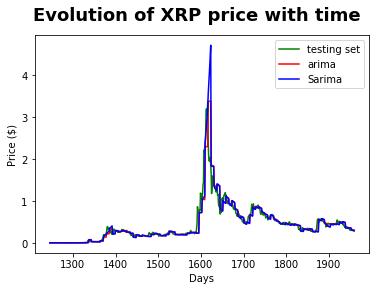

In [17]:
plot_forecasts(models, train, test, prediction_simulations, colors ,n_test)

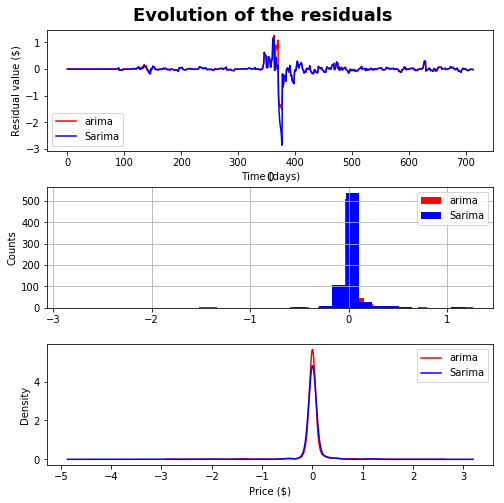

In [18]:
plot_residuals(models, test, prediction_simulations, colors,n_test)

<p style="text-align: justify">The residuals evolution and statistics, shows a Gaussian distribution which located close to a mean of 0, which is something we need to achieve while considering the residuals of a prediction.</p>

<p style="text-align: justify">In the next cell, different statistics of the residuals are printed for both models. We can see, that despite having a mean close to 0, the standard deviation for both models is too high in comparison of the values at stake. One main reason is due to the big jump in XRP price after 1600 days (in 2017), which created some disruption in the models with some high residual values. A glance at the percentiles for instance for the ARIMA model, shows that 75% of the values are predicted with less than 0.02$ difference, which is good already considering the price range of the currency on that period. </p>

In [19]:
print('ARIMA stats :', residuals_model['arima'].describe())
print()
print('SARIMA stats :', residuals_model['Sarima'].describe())

ARIMA stats :                 0
count  714.000000
mean     0.001446
std      0.195190
min     -1.517421
25%     -0.019282
50%      0.000015
75%      0.020928
max      1.263757

SARIMA stats :                 0
count  714.000000
mean    -0.009352
std      0.242242
min     -2.853618
25%     -0.015916
50%      0.000440
75%      0.023395
max      1.178087


## Extensions

<p style="text-align: justify">This section lists some ideas for extending this example that you may wish to explore.</p>

<ul>

<li><div style="text-align: justify"><strong>Change the walk-forward validation procedure</strong>. Here, we used a rolling window of 7 days to predict the next 7 days of the cryptocurrency price. Depending on the problem encountered, there might be an optimal window in which the models need to be trained and re-defined for improved results.</div></li>

<li><div style="text-align: justify"><strong>Correct predictions with residual errors</strong>. A model of forecast residual error is interesting, but it can also be useful to make better predictions. With a good estimate of forecast error at a time step, we can make better predictions. For example, we can add the expected forecast error to a prediction to correct it and in turn improve the skill of the model.</div></li>
    
<li><strong>Explore Data Preparation</strong>. The model was fit on the raw data directly. Explore whether standardization or normalization or even power transforms can further improve the skill of the AR model.</li>

</ul>